In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
SPY_m2 = pd.read_csv("./data/SPY/SPY_2019-01-02_24900000_57900000_message_10.csv", header=None)
SPY_m3 = pd.read_csv("./data/SPY/SPY_2019-01-03_24900000_57900000_message_10.csv", header=None)
SPY_m4 = pd.read_csv("./data/SPY/SPY_2019-01-04_24900000_57900000_message_10.csv", header=None)

SPY_ob2 = pd.read_csv("./data/SPY/SPY_2019-01-02_24900000_57900000_orderbook_10.csv", header=None)
SPY_ob3 = pd.read_csv("./data/SPY/SPY_2019-01-03_24900000_57900000_orderbook_10.csv", header=None)
SPY_ob4 = pd.read_csv("./data/SPY/SPY_2019-01-04_24900000_57900000_orderbook_10.csv", header=None)

/var/folders/lz/7z_hp6dd6q308wv0q5lw0zbr0000gn/T/ipykernel_98380/3308422439.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  SPY_m3 = pd.read_csv("./data/SPY/SPY_2019-01-03_24900000_57900000_message_10.csv", header=None)


In [3]:
SPY_m2 = SPY_m2.iloc[:,:-1]
SPY_m3 = SPY_m3.iloc[:,:-1]
SPY_m4 = SPY_m4.iloc[:,:-1]

In [4]:
M_header = ['time', 'event_type', 'order_ID',
            'size', 'price', 'direction']

SPY_m2.columns = M_header
SPY_m3.columns = M_header
SPY_m4.columns = M_header


OB_header = []
for i in range(1, SPY_ob2.shape[1]//4 + 1):
    OB_header.append(f'ask_price_{i}')
    OB_header.append(f'ask_size_{i}')
    OB_header.append(f'bid_price_{i}')
    OB_header.append(f'bid_size_{i}')

SPY_ob2.columns = OB_header
SPY_ob3.columns = OB_header
SPY_ob4.columns = OB_header

In [5]:
SPY_m2['time'] = pd.to_timedelta(SPY_m2['time'], unit='s')
SPY_m3['time'] = pd.to_timedelta(SPY_m3['time'], unit='s')
SPY_m4['time'] = pd.to_timedelta(SPY_m4['time'], unit='s')

# Define the base date
base_date2 = pd.Timestamp('2019-01-02')
base_date3 = pd.Timestamp('2019-01-03')
base_date4 = pd.Timestamp('2019-01-04')

# Add the timedelta (time_sec) to the base date
SPY_m2['datetime'] = base_date2 + SPY_m2['time']
SPY_m3['datetime'] = base_date3 + SPY_m3['time']
SPY_m4['datetime'] = base_date4 + SPY_m4['time']

SPY_m2.drop(columns=['time'], inplace=True)
SPY_m3.drop(columns=['time'], inplace=True)
SPY_m4.drop(columns=['time'], inplace=True)

In [6]:
SPY_m = pd.concat([SPY_m2, SPY_m3, SPY_m4], ignore_index=True)
SPY_ob = pd.concat([SPY_ob2, SPY_ob3, SPY_ob4], ignore_index=True)

In [7]:
# Creating event number
SPY_m['event_number'] = SPY_m.groupby('datetime').cumcount()

# Setting the composite index
SPY_m.set_index(['datetime', 'event_number'], inplace=True)

In [8]:
SPY_ob.index = SPY_m.index

In [9]:
SPY_ob_L1 = SPY_ob.iloc[:, :4]

In [10]:
SPY_m_execute = SPY_m[SPY_m['event_type'].isin([4, 5])]

In [11]:
SPY_m_execute_vis = SPY_m_execute[SPY_m_execute['event_type']==4]
SPY_m_execute_hid = SPY_m_execute[SPY_m_execute['event_type']==5]

/var/folders/lz/7z_hp6dd6q308wv0q5lw0zbr0000gn/T/ipykernel_98380/3254352531.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  r_SPY_m_execute_vis = SPY_m_execute_vis['size'].resample('30T', level='datetime').mean()
/var/folders/lz/7z_hp6dd6q308wv0q5lw0zbr0000gn/T/ipykernel_98380/3254352531.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  r_SPY_m_execute_hid = SPY_m_execute_hid['size'].resample('30T', level='datetime').mean()


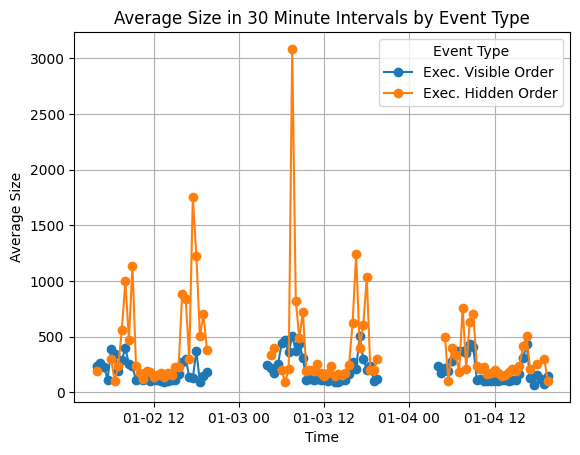

In [12]:
r_SPY_m_execute_vis = SPY_m_execute_vis['size'].resample('30T', level='datetime').mean()
r_SPY_m_execute_hid = SPY_m_execute_hid['size'].resample('30T', level='datetime').mean()


# Plotting the line plots of average size over 30 minute intervals for event types 4 and 5
# plt.figure(figsize=(12, 8))

plt.plot(r_SPY_m_execute_vis, marker='o', label='Exec. Visible Order')
plt.plot(r_SPY_m_execute_hid, marker='o', label='Exec. Hidden Order')

plt.xlabel('Time')
plt.ylabel('Average Size')
plt.title('Average Size in 30 Minute Intervals by Event Type')
plt.legend(title='Event Type')
plt.grid(True)
plt.show()

In [13]:
size_5q_ask = SPY_ob_L1['ask_size_1'].quantile(0.05)
size_95q_ask = SPY_ob_L1['ask_size_1'].quantile(0.95)
size_5q_bid = SPY_ob_L1['bid_size_1'].quantile(0.05)
size_95q_bid = SPY_ob_L1['bid_size_1'].quantile(0.95)

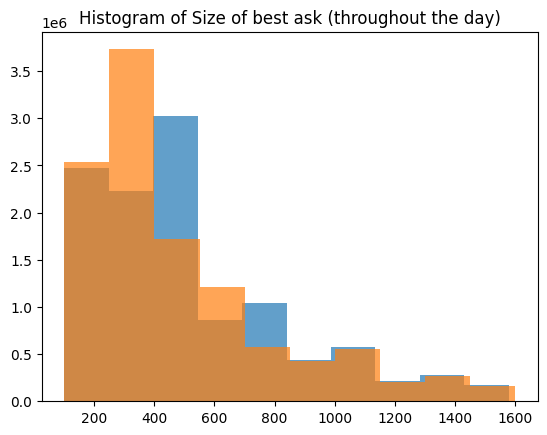

In [14]:
plt.hist(SPY_ob_L1[(size_5q_ask < SPY_ob_L1['ask_size_1']) & (SPY_ob_L1['ask_size_1'] < size_95q_ask)]['ask_size_1'], alpha=0.7)
plt.hist(SPY_ob_L1[(size_5q_bid < SPY_ob_L1['bid_size_1']) & (SPY_ob_L1['bid_size_1'] < size_95q_bid)]['bid_size_1'], alpha=0.7)
plt.title("Histogram of Size of best ask (throughout the day)")
plt.show()

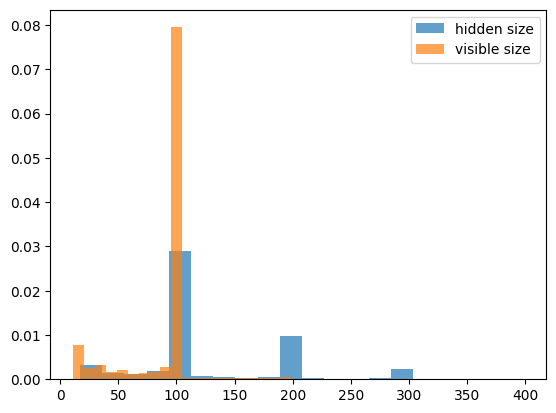

In [15]:
size_5q_hid_exec = SPY_m_execute_hid['size'].quantile(0.10)
size_95q_hid_exec = SPY_m_execute_hid['size'].quantile(0.90)
AAPL_M_exec_hid_f = SPY_m_execute_hid[(SPY_m_execute_hid['size'] > size_5q_hid_exec) & (SPY_m_execute_hid['size']< size_95q_hid_exec)]

size_5q_vis_exec = SPY_m_execute_vis['size'].quantile(0.10)
size_95q_vis_exec = SPY_m_execute_vis['size'].quantile(0.90)
AAPL_M_exec_vis_f = SPY_m_execute_vis[(SPY_m_execute_vis['size'] > size_5q_vis_exec) & (SPY_m_execute_vis['size']< size_95q_vis_exec)]

plt.hist(AAPL_M_exec_hid_f['size'],alpha=0.7, label='hidden size', bins=20, density=True)
plt.hist(AAPL_M_exec_vis_f['size'], alpha=0.7, label='visible size', bins=20, density=True)
plt.legend()
plt.show()

OFI Implementation - assuming no hidden liquidity. We use the OB data since it does not reflect hidden liqudity at all

In [16]:
valid_rows = (SPY_ob_L1['ask_price_1'] != 9999999999) & (SPY_ob_L1['bid_price_1'] != -9999999999)
SPY_ob_L1_f = SPY_ob_L1[valid_rows]

SPY_ob_L1_f['ask_price_1_change'] = SPY_ob_L1_f['ask_price_1'] - SPY_ob_L1_f['ask_price_1'].shift(1)
SPY_ob_L1_f['bid_price_1_change'] = SPY_ob_L1_f['bid_price_1'] - SPY_ob_L1_f['bid_price_1'].shift(1)
SPY_ob_L1_f['midprice'] = (SPY_ob_L1_f['ask_price_1'] + SPY_ob_L1_f['bid_price_1']) / 2

/var/folders/lz/7z_hp6dd6q308wv0q5lw0zbr0000gn/T/ipykernel_98380/3278070353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_ob_L1_f['ask_price_1_change'] = SPY_ob_L1_f['ask_price_1'] - SPY_ob_L1_f['ask_price_1'].shift(1)
/var/folders/lz/7z_hp6dd6q308wv0q5lw0zbr0000gn/T/ipykernel_98380/3278070353.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_ob_L1_f['bid_price_1_change'] = SPY_ob_L1_f['bid_price_1'] - SPY_ob_L1_f['bid_price_1'].shift(1)
/var/folders/lz/7z_hp6dd6q308wv0q5lw0zbr0000gn/T/ipyke

In [17]:
I_bid_ge = (SPY_ob_L1_f['bid_price_1_change'] >= 0).astype(int)
I_bid_le = (SPY_ob_L1_f['bid_price_1_change'] <= 0).astype(int)
I_ask_le = (SPY_ob_L1_f['ask_price_1_change'] <= 0).astype(int)
I_ask_ge = (SPY_ob_L1_f['ask_price_1_change'] >= 0).astype(int)

In [18]:
SPY_ob_L1_f['en'] = (I_bid_ge * SPY_ob_L1_f['bid_size_1'] - I_bid_le * SPY_ob_L1_f['bid_size_1'].shift(1) - 
            I_ask_le * SPY_ob_L1_f['ask_size_1'] + I_ask_ge * SPY_ob_L1_f['ask_size_1'].shift(1))

time_interval = '10S'
SPY_ofi = SPY_ob_L1_f[['en', 'midprice']].resample(time_interval, level='datetime').agg({
    'en': 'sum',
    'midprice': 'first'
})

/var/folders/lz/7z_hp6dd6q308wv0q5lw0zbr0000gn/T/ipykernel_98380/4292612993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPY_ob_L1_f['en'] = (I_bid_ge * SPY_ob_L1_f['bid_size_1'] - I_bid_le * SPY_ob_L1_f['bid_size_1'].shift(1) -
/var/folders/lz/7z_hp6dd6q308wv0q5lw0zbr0000gn/T/ipykernel_98380/4292612993.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  SPY_ofi = SPY_ob_L1_f[['en', 'midprice']].resample(time_interval, level='datetime').agg({


In [19]:
SPY_ofi['change_midprice'] = SPY_ofi['midprice'].diff()

In [20]:
SPY_ofi_f = SPY_ofi.dropna()

In [21]:
quantiles = SPY_ofi_f['change_midprice'].quantile([0.05, 0.95])
q5, q95 = quantiles.iloc[0], quantiles.iloc[1]

# Filter the dataframe to keep rows where 'change_midprice' is between the 5th and 95th quantiles
SPY_ofi_f_qt = SPY_ofi_f[(SPY_ofi_f['change_midprice'] >= q5) & (SPY_ofi_f['change_midprice'] <= q95)]

(array([ 441.,  748., 1028., 1916., 2073., 3510., 1957.,  974.,  746.,
         451.]),
 array([-900., -720., -540., -360., -180.,    0.,  180.,  360.,  540.,
         720.,  900.]),
 <BarContainer object of 10 artists>)

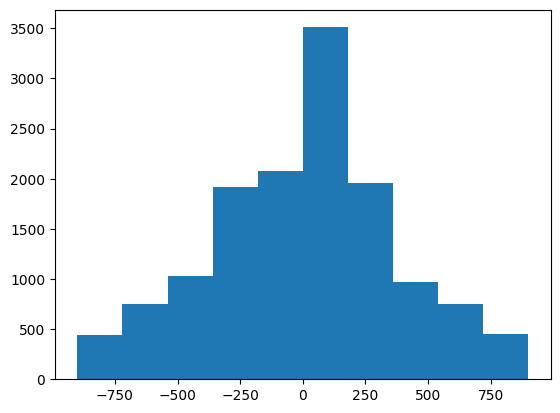

In [22]:
plt.hist(SPY_ofi_f_qt['change_midprice'])

In [23]:
lm_OFI = smf.ols(formula="""change_midprice ~ en - 1""", data=SPY_ofi_f_qt).fit()
lm_OFI.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        change_midprice   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              20.08
Date:                Sat, 29 Jun 2024   Prob (F-statistic):                    7.50e-06
Time:                        17:59:46   Log-Likelihood:                     -1.0157e+05
No. Observations:               13844   AIC:                                  2.032e+05
Df Residuals:                   13843   BIC:                                  2.032e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
en             0.0011      0.000      4.481      0.000       0.001       0.002
==============================================================================
Omnibus:                        9.604   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                8.662
Skew:                           0.011   Prob(JB):                       0.0132
Kurtosis:                       2.880   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Variable is significant.

### Aggressiveness - On the Dark Side of the Market

In [26]:
SPY_m_execute_hid_merged = SPY_m_execute_hid.merge(SPY_ob_L1[['bid_price_1', 'ask_price_1']], left_index=True, right_index=True)

Note, all direction is 1

In [36]:
SPY_m_execute_hid_merged['own_aggressive'] = SPY_m_execute_hid_merged['price'] - SPY_m_execute_hid_merged['bid_price_1']
SPY_m_execute_hid_merged['opp_aggressive'] = SPY_m_execute_hid_merged['ask_price_1'] - SPY_m_execute_hid_merged['price']


Text(0.5, 1.0, 'Plot of Own Aggressiveness')

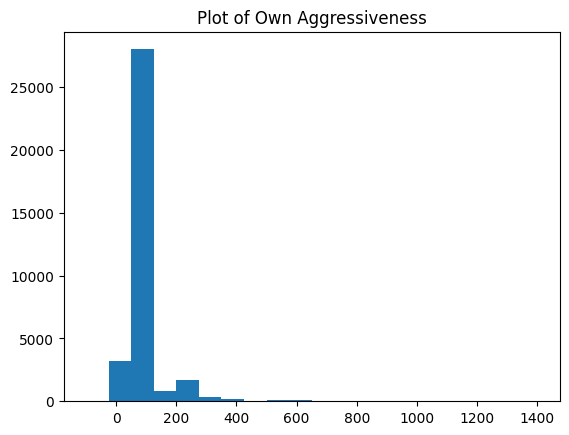

In [39]:
plt.hist(SPY_m_execute_hid_merged['own_aggressive'][SPY_m_execute_hid_merged['own_aggressive'] < 1500], bins=20)
plt.title("Plot of Own Aggressiveness")
